# Vizualisation Stats Dataset

In [1]:
import os
import glob
import random
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import cv2
import numpy as np

In [2]:
# --- Configuration ---
# Chemin vers le répertoire contenant les dossiers des types de cellules
data_path = "/home/anthony-sauvage/repo/BloodCellClassification/app/data/raw/bloodcells_dataset"
def get_image_path(dataset_map, subdir_name: str, index_img: int):
    list_img = dataset_map[subdir_name]
    img_path = os.path.join(data_path, f"{subdir_name}/{list_img[index_img]}")
    #print(img_path)
    return img_path

def map_subdirs_to_files(dir_path):
    """
    Crée un dictionnaire qui mappe directement chaque nom de sous-répertoire
    à la liste de ses fichiers (images).

    Format de sortie :
    {
        "nom_sous_repertoire_1": ["img1.jpg", "img2.jpg"],
        "nom_sous_repertoire_2": ["imgA.jpg", "imgB.jpg"],
        ...
    }

    Args:
        dir_path (str): Le chemin vers le répertoire principal.

    Returns:
        dict: Un dictionnaire où les clés sont les noms des sous-répertoires
              et les valeurs sont les listes de noms de fichiers.
              Retourne un dictionnaire vide si le chemin n'est pas un répertoire valide ou est vide.
    """
    direct_mapping = {}
    if not os.path.isdir(dir_path):
        print(f"Le chemin '{dir_path}' n'est pas un répertoire valide.")
        return direct_mapping

    for item_name in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item_name)
        
        # On s'assure que c'est bien un sous-répertoire
        if os.path.isdir(item_path):
            # Liste uniquement les fichiers dans chaque sous-répertoire
            files_in_subdir = [f for f in os.listdir(item_path) if os.path.isfile(os.path.join(item_path, f))]
            direct_mapping[item_name] = files_in_subdir # Le nom du sous-répertoire est la clé
            
    return direct_mapping

dataset_map = map_subdirs_to_files(data_path)


## Visualisation de la répartition des données par type de cellule

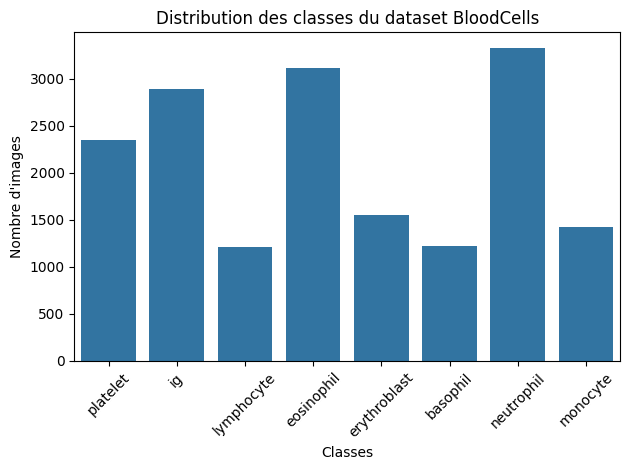

On observe un déséquilibre entre les classes. 
Les classes 'platelet','ig', eosinophil' et 'neutrophil' sont surreprésentées
Il faudra donc réaliser un sous-echantillonnage de ces classes majoritaires


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def show_class_distribution(dataset_map):
    x = []
    y = []
    for k in dataset_map.keys():
        x.append(k) 
        y.append(len(dataset_map[k]))
    
    sns.barplot(x=x, y=y)
    plt.title("Distribution des classes du dataset BloodCells")
    plt.xticks(rotation=45)  # Incline les étiquettes de 45 degrés
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'images")
    plt.tight_layout()  # Ajuste automatiquement les marges pour éviter que les étiquettes soient coupées
    plt.show()
    
show_class_distribution(dataset_map)
print("On observe un déséquilibre entre les classes. \n\
Les classes 'platelet','ig', eosinophil' et 'neutrophil' sont surreprésentées\n\
Il faudra donc réaliser un sous-echantillonnage de ces classes majoritaires")

## Analyse de la qualité des images dans chaque dossier de cellules types

In [38]:
import cv2
def is_image_corrupted(image_path):
    """
    Détecte si une image JPG est corrompue ou non.
    
    Args:
        image_path (str): Chemin vers l'image à vérifier
        
    Returns:
        bool: True si l'image est corrompue, False sinon
    """
    # Vérifier si le fichier existe
    if not os.path.isfile(image_path):
        print(f"Erreur: Le fichier {image_path} n'existe pas.")
        return True
    
    # Vérifier si le fichier est vide
    if os.path.getsize(image_path) == 0:
        print(f"Erreur: Le fichier {image_path} est vide.")
        return True
    
    try:
        # Essayer de lire l'image avec OpenCV
        img = cv2.imread(image_path)
        
        # Vérifier si l'image a été correctement chargée
        if img is None:
            print(f"Erreur: Impossible de lire l'image {image_path}.")
            return True
        
        # Vérifier si l'image a des dimensions valides
        if img.shape[0] <= 0 or img.shape[1] <= 0:
            print(f"Erreur: L'image {image_path} a des dimensions invalides.")
            return True
            
        # Vérifier si l'image contient des données valides
        if np.sum(img) == 0:
            print(f"Erreur: L'image {image_path} ne contient que des pixels noirs.")
            return True
        
        # L'image semble valide
        return False
        
    except Exception as e:
        print(f"Erreur lors de la lecture de l'image {image_path}: {str(e)}")
        return True


In [48]:
for cell_type in dataset_map.keys():
    print("Analyse des images de type: ", cell_type)
    for i, file in enumerate(os.listdir(os.path.join(data_path, cell_type))):
        
        image_path = get_image_path(dataset_map, cell_type, index_img=i)
        if is_image_corrupted(image_path):
            print(f"Image corrompue: {image_path}")
            
print("Fin de l'analyse. Aucune image n'est corrompue")

Analyse des images de type:  platelet
Analyse des images de type:  ig
Analyse des images de type:  lymphocyte
Analyse des images de type:  eosinophil
Analyse des images de type:  erythroblast
Analyse des images de type:  basophil
Analyse des images de type:  neutrophil
Analyse des images de type:  monocyte
Fin de l'analyse. Aucune image n'est corrompue


# Analyse des statistiques des pixels des images du dataset sur les canaux R, G et B

Image path: /home/anthony-sauvage/repo/BloodCellClassification/app/data/raw/bloodcells_dataset/ig/MY_210359.jpg


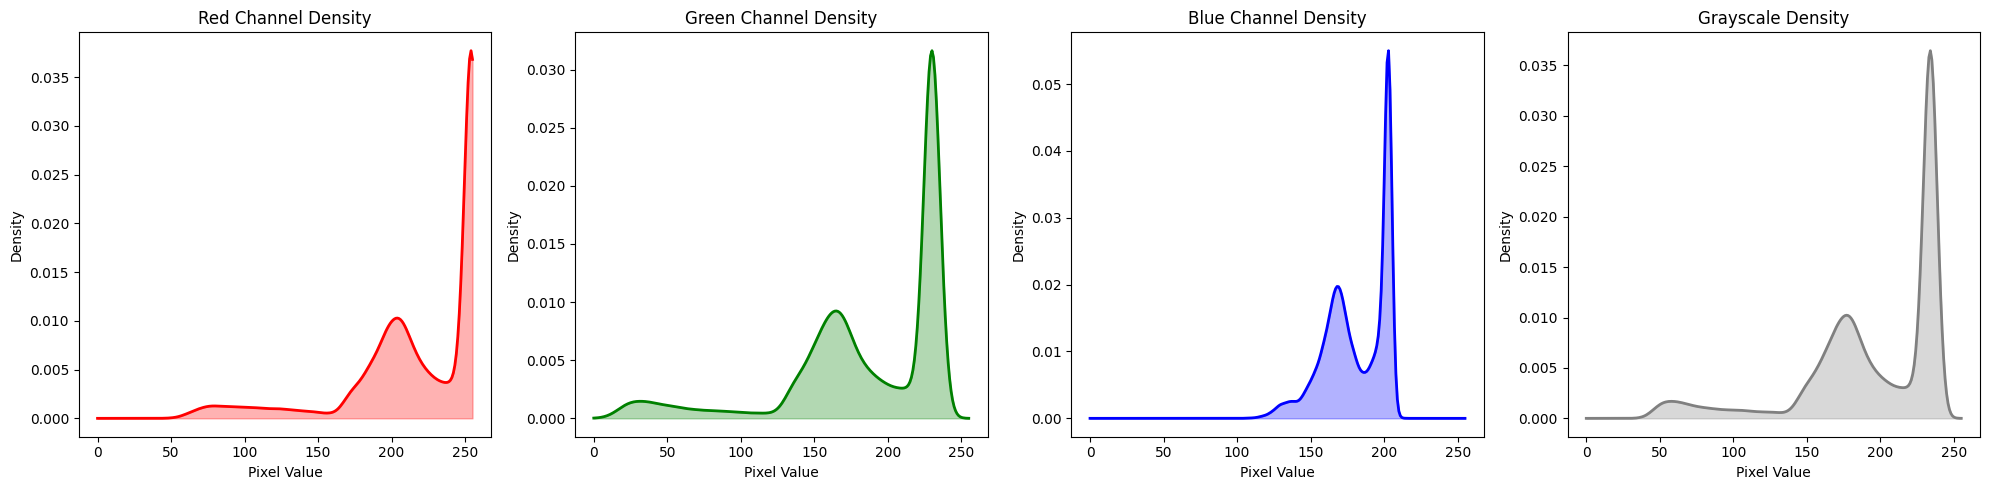

Red channel - Min: 45, Max: 255, Mean: 216.78
Green channel - Min: 0, Max: 247, Mean: 185.78
Blue channel - Min: 100, Max: 216, Mean: 181.25
Grayscale - Min: 35, Max: 242, Mean: 194.53


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from scipy import stats

def plot_R_G_B_density_curves(dataset_map, base_path, subdir_name, index_img):
    """
    Plot density curves of R, G, B channels and grayscale for a specific image using cv2.
    
    Parameters:
    -----------
    dataset_map : dict
        Dictionary mapping subdirectories to lists of image files.
    base_path : str
        Base path to the dataset.
    subdir_name : str
        Name of the subdirectory containing the target image.
    index_img : int
        Index of the image in the dataset_map[subdir_name] list.
    
    Returns:
    --------
    None
        Displays the density curves of R, G, B channels and grayscale.
    """
    # Get the image path using the dataset map
    list_img = dataset_map[subdir_name]
    img_path = os.path.join(base_path, f"{subdir_name}/{list_img[index_img]}")
    print(f"Image path: {img_path}")
    
    # Load the image using cv2
    img = cv2.imread(img_path)
    
    # Check if the image is loaded correctly
    if img is None:
        print(f"Error: Could not load image at {img_path}")
        return
    
    # Convert BGR (cv2 default) to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale using cv2
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Extract R, G, B channels
    r_channel = img_rgb[:, :, 0]
    g_channel = img_rgb[:, :, 1]
    b_channel = img_rgb[:, :, 2]
    
    # Flatten the channels
    r_flat = r_channel.flatten()
    g_flat = g_channel.flatten()
    b_flat = b_channel.flatten()
    gray_flat = img_gray.flatten()
    
    # Create figure with 4 subplots (one for each channel + grayscale)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Define x range for density estimation (0-255 for 8-bit images)
    x = np.linspace(0, 255, 256)
    
    # Plot density curves for each channel
    # Red channel
    kde_r = stats.gaussian_kde(r_flat)
    axes[0].plot(x, kde_r(x), color='red', linewidth=2)
    axes[0].fill_between(x, kde_r(x), alpha=0.3, color='red')
    axes[0].set_title('Red Channel Density')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Density')
    
    # Green channel
    kde_g = stats.gaussian_kde(g_flat)
    axes[1].plot(x, kde_g(x), color='green', linewidth=2)
    axes[1].fill_between(x, kde_g(x), alpha=0.3, color='green')
    axes[1].set_title('Green Channel Density')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_ylabel('Density')
    
    # Blue channel
    kde_b = stats.gaussian_kde(b_flat)
    axes[2].plot(x, kde_b(x), color='blue', linewidth=2)
    axes[2].fill_between(x, kde_b(x), alpha=0.3, color='blue')
    axes[2].set_title('Blue Channel Density')
    axes[2].set_xlabel('Pixel Value')
    axes[2].set_ylabel('Density')
    
    # Grayscale channel
    kde_gray = stats.gaussian_kde(gray_flat)
    axes[3].plot(x, kde_gray(x), color='gray', linewidth=2)
    axes[3].fill_between(x, kde_gray(x), alpha=0.3, color='gray')
    axes[3].set_title('Grayscale Density')
    axes[3].set_xlabel('Pixel Value')
    axes[3].set_ylabel('Density')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print some statistics about each channel
    print(f"Red channel - Min: {r_flat.min()}, Max: {r_flat.max()}, Mean: {r_flat.mean():.2f}")
    print(f"Green channel - Min: {g_flat.min()}, Max: {g_flat.max()}, Mean: {g_flat.mean():.2f}")
    print(f"Blue channel - Min: {b_flat.min()}, Max: {b_flat.max()}, Mean: {b_flat.mean():.2f}")
    print(f"Grayscale - Min: {gray_flat.min()}, Max: {gray_flat.max()}, Mean: {gray_flat.mean():.2f}")

# Example usage:
# Assuming you have already defined:
# - dataset_map = map_subdirs_to_files(data_path)
# - data_path = "/path/to/your/dataset"
# 
# Then you can call:
plot_R_G_B_density_curves(dataset_map, data_path, "ig", 0)

In [4]:
def plot_average_RGB_distribution(dataset_map, base_path, subdir_name, batch_size=20, sample_size=None, bins=50, fig=None, axes=None):
    """
    Calculate and optionally plot average density curves of R, G, B channels and grayscale for all images in a subdirectory.
    Uses batch processing and histogram-based approach for better performance.
    
    Parameters:
    -----------
    dataset_map : dict
        Dictionary mapping subdirectories to lists of image files.
    base_path : str
        Base path to the dataset.
    subdir_name : str
        Name of the subdirectory containing the images.
    batch_size : int, optional (default=20)
        Number of images to process in each batch.
    sample_size : int, optional (default=None)
        Number of pixels to sample from each image for KDE estimation.
        If None, uses all pixels (slower but more accurate).
    bins : int, optional (default=50)
        Number of bins for the histogram approach.
    fig : matplotlib.figure.Figure, optional (default=None)
        Figure to plot on. If None, a new figure is created if needed.
    axes : list of matplotlib.axes.Axes, optional (default=None)
        Axes to plot on. If None, new axes are created if needed.
    
    Returns:
    --------
    tuple
        (fig, axes, stats_dict) where:
        - fig is the matplotlib figure object (None if no plotting was done)
        - axes is a list of the four axes for R, G, B, Gray plots (None if no plotting was done)
        - stats_dict is a dictionary containing the calculated statistics
    """
    # Check if the subdirectory exists in the dataset map
    if subdir_name not in dataset_map:
        print(f"Error: Subdirectory '{subdir_name}' not found in dataset map")
        return None, None, None
    
    # Get the list of images in the subdirectory
    list_img = dataset_map[subdir_name]
    num_images = len(list_img)
    
    if num_images == 0:
        print(f"Error: No images found in subdirectory '{subdir_name}'")
        return None, None, None
    
    print(f"Processing {num_images} images from subdirectory '{subdir_name}'...")
    
    # Initialize arrays for histograms
    r_hist_total = np.zeros(bins)
    g_hist_total = np.zeros(bins)
    b_hist_total = np.zeros(bins)
    gray_hist_total = np.zeros(bins)
    
    # Statistics accumulators
    r_mins, r_maxs, r_means = [], [], []
    g_mins, g_maxs, g_means = [], [], []
    b_mins, b_maxs, b_means = [], [], []
    gray_mins, gray_maxs, gray_means = [], [], []
    
    # Process images in batches
    for batch_start in range(0, num_images, batch_size):
        batch_end = min(batch_start + batch_size, num_images)
        batch_images = list_img[batch_start:batch_end]
        batch_size_actual = len(batch_images)
        
        print(f"Processing batch {batch_start//batch_size + 1}/{(num_images-1)//batch_size + 1} (images {batch_start+1}-{batch_end})")
        
        # Process each image in the batch
        for img_name in batch_images:
            # Construct the full image path
            img_path = os.path.join(base_path, f"{subdir_name}/{img_name}")
            
            # Load the image using cv2
            img = cv2.imread(img_path)
            
            # Skip if image couldn't be loaded
            if img is None:
                print(f"Warning: Could not load image at {img_path}. Skipping...")
                continue
            
            # Convert BGR (cv2 default) to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Convert to grayscale using cv2
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Extract R, G, B channels
            r_channel = img_rgb[:, :, 0]
            g_channel = img_rgb[:, :, 1]
            b_channel = img_rgb[:, :, 2]
            
            # Sample pixels if sample_size is specified
            if sample_size is not None:
                h, w = r_channel.shape
                total_pixels = h * w
                if total_pixels > sample_size:
                    # Create a random sample of pixel indices
                    indices = np.random.choice(total_pixels, sample_size, replace=False)
                    r_flat = r_channel.flatten()[indices]
                    g_flat = g_channel.flatten()[indices]
                    b_flat = b_channel.flatten()[indices]
                    gray_flat = img_gray.flatten()[indices]
                else:
                    r_flat = r_channel.flatten()
                    g_flat = g_channel.flatten()
                    b_flat = b_channel.flatten()
                    gray_flat = img_gray.flatten()
            else:
                r_flat = r_channel.flatten()
                g_flat = g_channel.flatten()
                b_flat = b_channel.flatten()
                gray_flat = img_gray.flatten()
            
            # Collect statistics
            r_mins.append(r_flat.min())
            r_maxs.append(r_flat.max())
            r_means.append(r_flat.mean())
            
            g_mins.append(g_flat.min())
            g_maxs.append(g_flat.max())
            g_means.append(g_flat.mean())
            
            b_mins.append(b_flat.min())
            b_maxs.append(b_flat.max())
            b_means.append(b_flat.mean())
            
            gray_mins.append(gray_flat.min())
            gray_maxs.append(gray_flat.max())
            gray_means.append(gray_flat.mean())
            
            # Calculate histograms for each channel
            r_hist, _ = np.histogram(r_flat, bins=bins, range=(0, 255), density=True)
            g_hist, _ = np.histogram(g_flat, bins=bins, range=(0, 255), density=True)
            b_hist, _ = np.histogram(b_flat, bins=bins, range=(0, 255), density=True)
            gray_hist, _ = np.histogram(gray_flat, bins=bins, range=(0, 255), density=True)
            
            # Accumulate histograms
            r_hist_total += r_hist
            g_hist_total += g_hist
            b_hist_total += b_hist
            gray_hist_total += gray_hist
    
    # Calculate average histograms
    r_hist_avg = r_hist_total / num_images
    g_hist_avg = g_hist_total / num_images
    b_hist_avg = b_hist_total / num_images
    gray_hist_avg = gray_hist_total / num_images
    
    # Create x-axis for plotting (bin centers)
    bin_edges = np.linspace(0, 255, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Compile statistics
    stats_dict = {
        'subdir_name': subdir_name,
        'num_images': num_images,
        'r_stats': {
            'min': np.mean(r_mins),
            'max': np.mean(r_maxs),
            'mean': np.mean(r_means)
        },
        'g_stats': {
            'min': np.mean(g_mins),
            'max': np.mean(g_maxs),
            'mean': np.mean(g_means)
        },
        'b_stats': {
            'min': np.mean(b_mins),
            'max': np.mean(b_maxs),
            'mean': np.mean(b_means)
        },
        'gray_stats': {
            'min': np.mean(gray_mins),
            'max': np.mean(gray_maxs),
            'mean': np.mean(gray_means)
        },
        'bin_centers': bin_centers,
        'r_hist_avg': r_hist_avg,
        'g_hist_avg': g_hist_avg,
        'b_hist_avg': b_hist_avg,
        'gray_hist_avg': gray_hist_avg
    }
    
    # If axes are provided or we need to create a new figure
    if axes is not None or (axes is None and fig is None):
        # Create figure with 4 subplots if not provided
        if fig is None or axes is None:
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Plot average density curves for each channel
        # Red channel
        axes[0].plot(bin_centers, r_hist_avg, color='red', linewidth=2)
        axes[0].fill_between(bin_centers, r_hist_avg, alpha=0.3, color='red')
        axes[0].set_title(f'Average Red Channel Density\n({subdir_name})')
        axes[0].set_xlabel('Pixel Value')
        axes[0].set_ylabel('Density')
        
        # Green channel
        axes[1].plot(bin_centers, g_hist_avg, color='green', linewidth=2)
        axes[1].fill_between(bin_centers, g_hist_avg, alpha=0.3, color='green')
        axes[1].set_title(f'Average Green Channel Density\n({subdir_name})')
        axes[1].set_xlabel('Pixel Value')
        axes[1].set_ylabel('Density')
        
        # Blue channel
        axes[2].plot(bin_centers, b_hist_avg, color='blue', linewidth=2)
        axes[2].fill_between(bin_centers, b_hist_avg, alpha=0.3, color='blue')
        axes[2].set_title(f'Average Blue Channel Density\n({subdir_name})')
        axes[2].set_xlabel('Pixel Value')
        axes[2].set_ylabel('Density')
        
        # Grayscale channel
        axes[3].plot(bin_centers, gray_hist_avg, color='gray', linewidth=2)
        axes[3].fill_between(bin_centers, gray_hist_avg, alpha=0.3, color='gray')
        axes[3].set_title(f'Average Grayscale Density\n({subdir_name})')
        axes[3].set_xlabel('Pixel Value')
        axes[3].set_ylabel('Density')
        
        # Adjust layout
        plt.suptitle(f'Average RGB and Grayscale Distribution for {num_images} Images in {subdir_name}')
        plt.tight_layout()
    
    # Print average statistics for each channel
    print(f"\nAverage Statistics for {num_images} images in '{subdir_name}':")
    print(f"Red channel - Min: {np.mean(r_mins):.2f}, Max: {np.mean(r_maxs):.2f}, Mean: {np.mean(r_means):.2f}")
    print(f"Green channel - Min: {np.mean(g_mins):.2f}, Max: {np.mean(g_maxs):.2f}, Mean: {np.mean(g_means):.2f}")
    print(f"Blue channel - Min: {np.mean(b_mins):.2f}, Max: {np.mean(b_maxs):.2f}, Mean: {np.mean(b_means):.2f}")
    print(f"Grayscale - Min: {np.mean(gray_mins):.2f}, Max: {np.mean(gray_maxs):.2f}, Mean: {np.mean(gray_means):.2f}")
    
    return fig, axes, stats_dict

In [5]:
def plot_all_subdirs_RGB_distribution(dataset_map, base_path, batch_size=20, sample_size=None, bins=50):
    """
    Plot average RGB and grayscale distribution for all subdirectories in the dataset map.
    
    Parameters:
    -----------
    dataset_map : dict
        Dictionary mapping subdirectories to lists of image files.
    base_path : str
        Base path to the dataset.
    batch_size : int, optional (default=20)
        Number of images to process in each batch.
    sample_size : int, optional (default=None)
        Number of pixels to sample from each image for KDE estimation.
        If None, uses all pixels (slower but more accurate).
    bins : int, optional (default=50)
        Number of bins for the histogram approach.
    
    Returns:
    --------
    tuple
        (fig, all_stats) where:
        - fig is the matplotlib figure object
        - all_stats is a dictionary containing statistics for all subdirectories
    """
    # Get the number of subdirectories
    subdirs = list(dataset_map.keys())
    num_subdirs = len(subdirs)
    
    if num_subdirs == 0:
        print("Error: No subdirectories found in dataset map")
        return None, None
    
    # Create a figure with 4 columns (R, G, B, Gray) and num_subdirs rows
    fig, axes = plt.subplots(num_subdirs, 4, figsize=(20, 5 * num_subdirs))
    
    # If there's only one subdirectory, make sure axes is still a 2D array
    if num_subdirs == 1:
        axes = np.array([axes])
    
    # Dictionary to store all statistics
    all_stats = {}
    
    # Process each subdirectory
    for i, subdir in enumerate(subdirs):
        print(f"\nProcessing subdirectory {i+1}/{num_subdirs}: {subdir}")
        
        # Get the row of axes for this subdirectory
        subdir_axes = axes[i]
        
        # Process the subdirectory
        _, _, stats = plot_average_RGB_distribution(
            dataset_map=dataset_map,
            base_path=base_path,
            subdir_name=subdir,
            batch_size=batch_size,
            sample_size=sample_size,
            bins=bins,
            fig=fig,
            axes=subdir_axes
        )
        
        # Store statistics
        if stats is not None:
            all_stats[subdir] = stats
    
    # Set a global title
    plt.suptitle(f'Average RGB and Grayscale Distribution Comparison Across {num_subdirs} Classes', fontsize=16)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the suptitle
    
    return fig, all_stats

In [6]:
def save_RGB_distribution_plots(fig, output_dir, filename="rgb_distribution_comparison.png", dpi=300):
    """
    Save the RGB distribution plots to a file.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        Figure object to save.
    output_dir : str
        Directory to save the figure to.
    filename : str, optional (default="rgb_distribution_comparison.png")
        Name of the output file.
    dpi : int, optional (default=300)
        Resolution of the output image.
    
    Returns:
    --------
    str
        Path to the saved file.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Construct the full output path
    output_path = os.path.join(output_dir, filename)
    
    # Save the figure
    fig.savefig(output_path, dpi=dpi, bbox_inches='tight')
    
    print(f"Figure saved to {output_path}")
    
    return output_path


Processing subdirectory 1/8: platelet
Processing 2348 images from subdirectory 'platelet'...
Processing batch 1/118 (images 1-20)
Processing batch 2/118 (images 21-40)
Processing batch 3/118 (images 41-60)
Processing batch 4/118 (images 61-80)
Processing batch 5/118 (images 81-100)
Processing batch 6/118 (images 101-120)
Processing batch 7/118 (images 121-140)
Processing batch 8/118 (images 141-160)
Processing batch 9/118 (images 161-180)
Processing batch 10/118 (images 181-200)
Processing batch 11/118 (images 201-220)
Processing batch 12/118 (images 221-240)
Processing batch 13/118 (images 241-260)
Processing batch 14/118 (images 261-280)
Processing batch 15/118 (images 281-300)
Processing batch 16/118 (images 301-320)
Processing batch 17/118 (images 321-340)
Processing batch 18/118 (images 341-360)
Processing batch 19/118 (images 361-380)
Processing batch 20/118 (images 381-400)
Processing batch 21/118 (images 401-420)
Processing batch 22/118 (images 421-440)
Processing batch 23/118

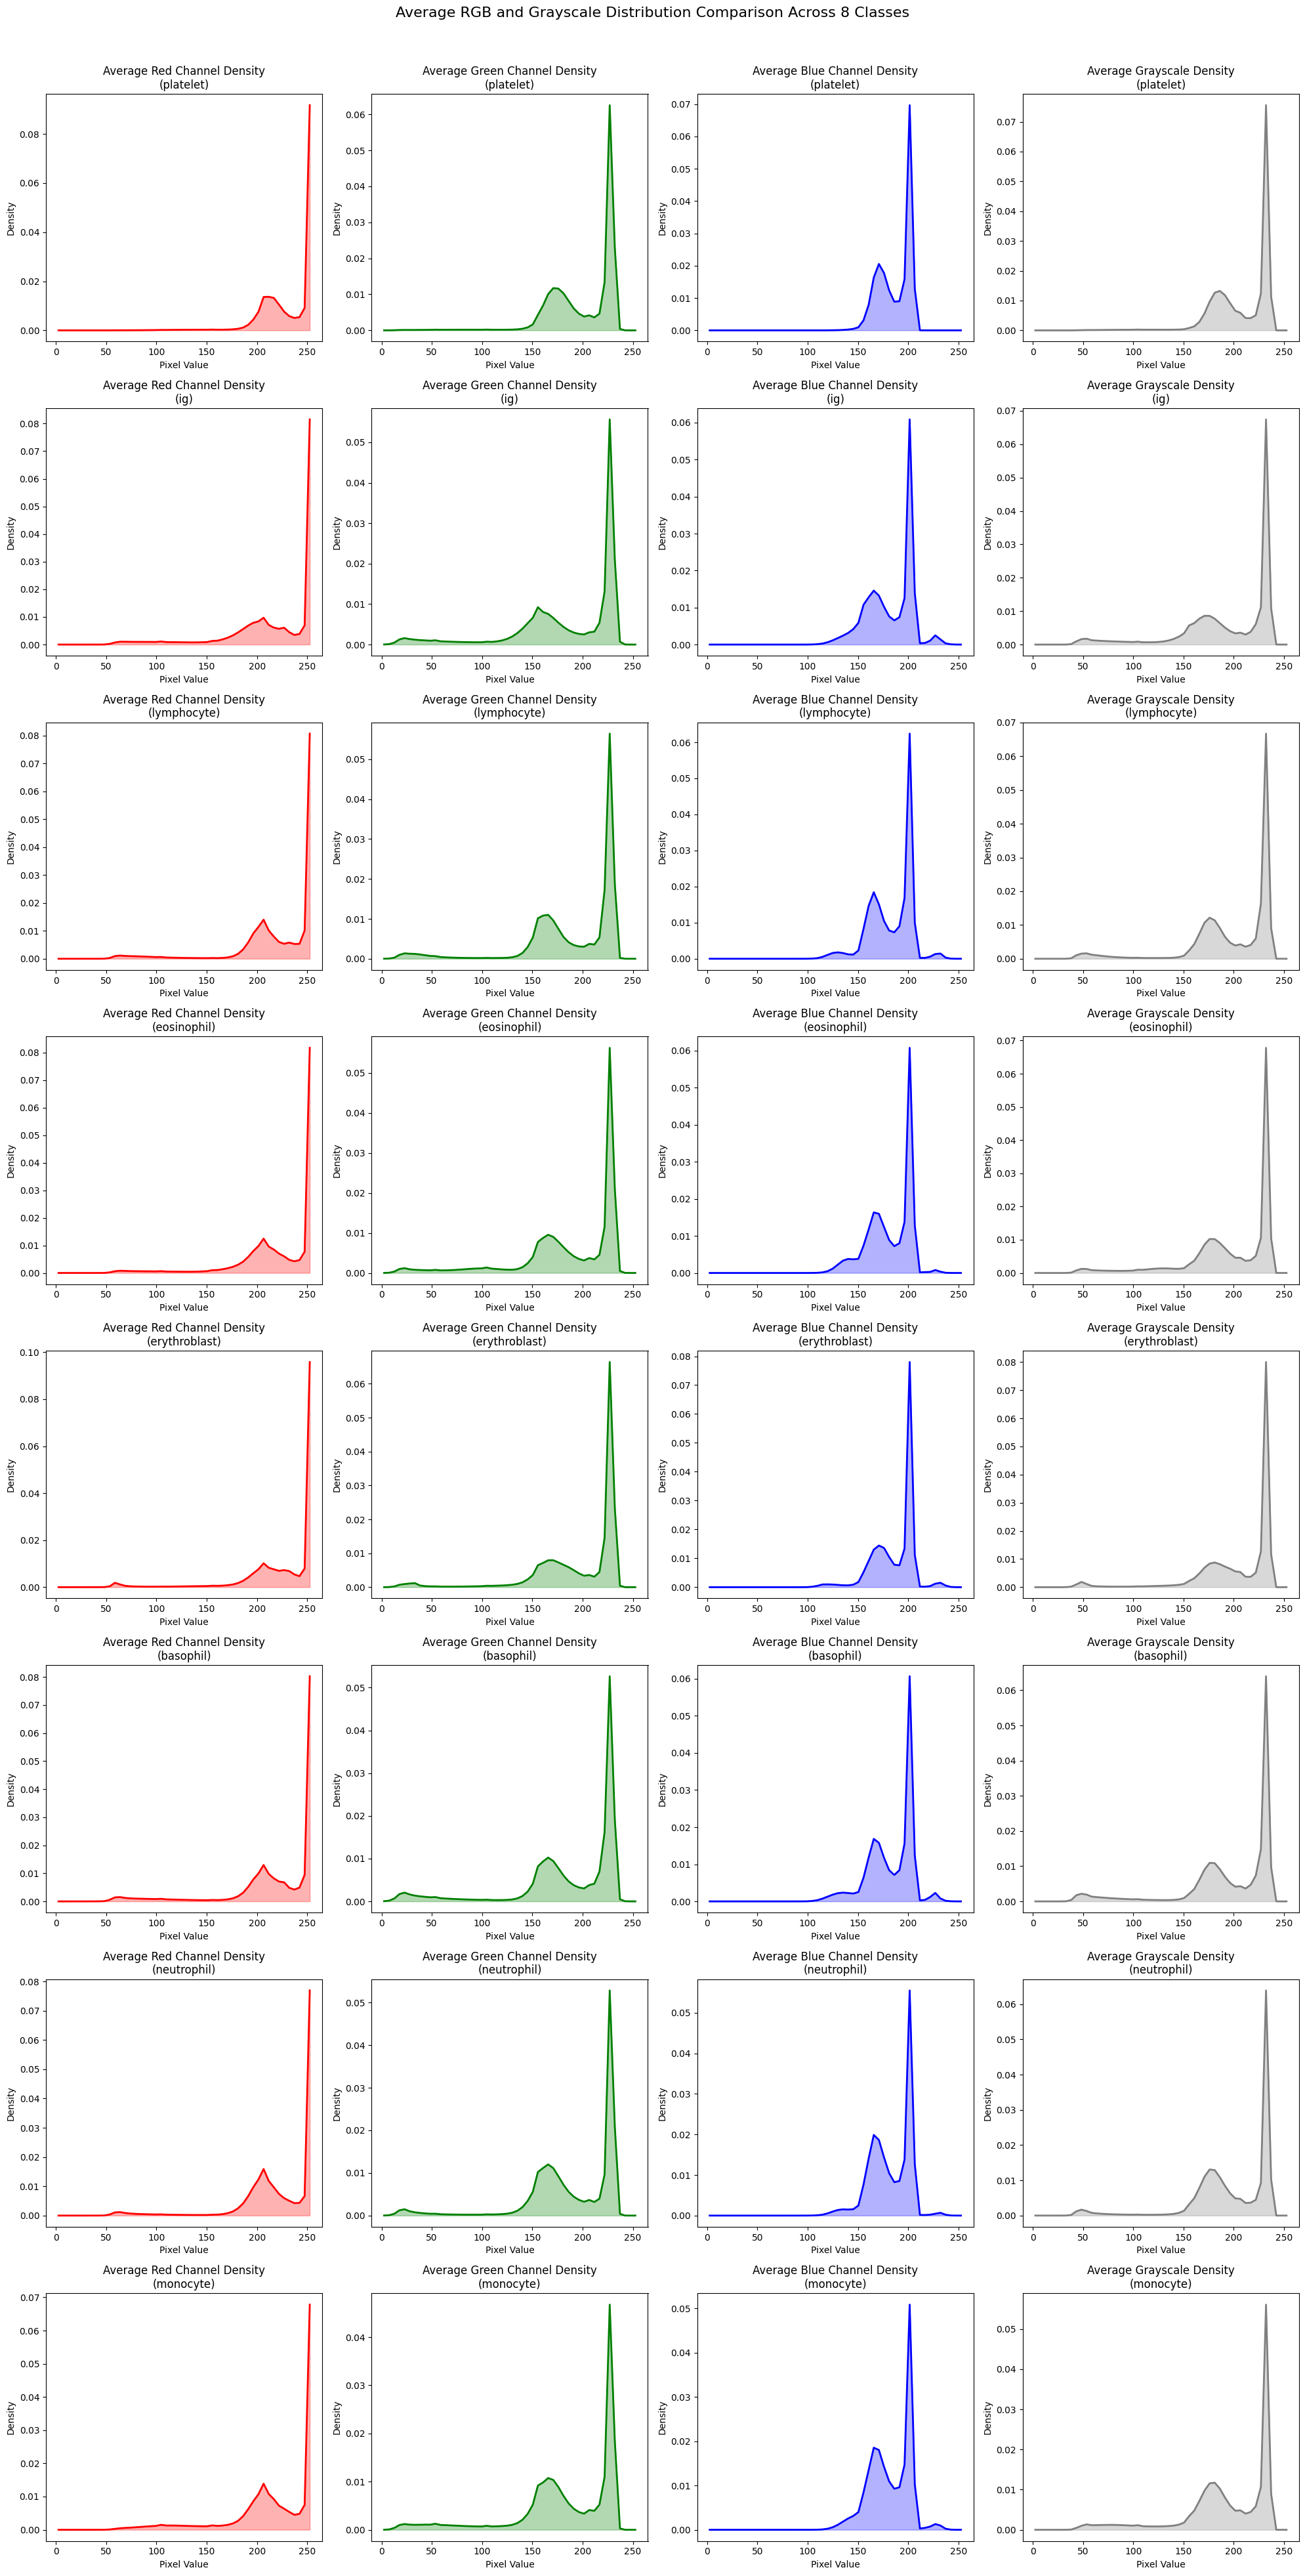

Figure saved to ./output/rgb_comparison.png


'./output/rgb_comparison.png'

In [7]:
# Exemple d'utilisation
fig, all_stats = plot_all_subdirs_RGB_distribution(dataset_map, data_path)
plt.show()

# Optionnel : sauvegarder la figure
save_RGB_distribution_plots(fig, output_dir="./output", filename="rgb_comparison.png")

## Conclusion
Toutes les images du dataset sont valides. Pour notre prétraitement, il est nécessaire d'effectuer un sous-echantillonnage de ces classes majoritaires 'platelet','ig', eosinophil' et 'neutrophil'.
Ce sous-échantillonnage consistera à sélectionner de manière aléatoire un échantillon de 1500 images pour chaque classe majoritaire.